In [52]:
import numpy as np
import matplotlib.pyplot as plt
import esn
from esn import EchoStateNetwork, LeastMeanSquares
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.datasets import mnist


In [53]:
import importlib

importlib.reload(esn)
from esn import EchoStateNetwork, LeastMeanSquares

In [54]:
# load mnist data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# normalize
x_train = x_train / 255
x_test = x_test / 255

permute = False
# permute
if permute:
    np.random.seed(0)
    perm = np.random.permutation(x_train.shape[1])
    inv_perm = np.argsort(perm)

    x_train = x_train[:, perm]


In [55]:
x_train_sub = x_train[:1000]
y_train_sub = y_train[:1000]
x_valid_sub = x_train[1000:2000]
y_valid_sub = y_train[1000:2000]

x_test_sub = x_test[:1000]
y_test_sub = y_test[:1000]

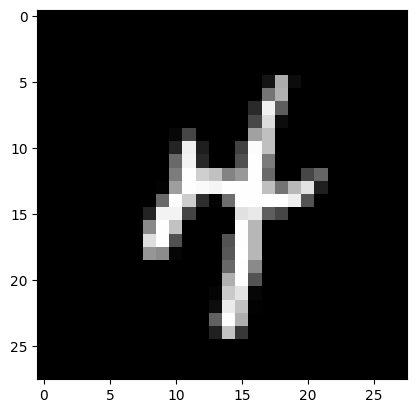

In [56]:
plt.imshow(x_train_sub[342].reshape(28, 28), cmap='gray')


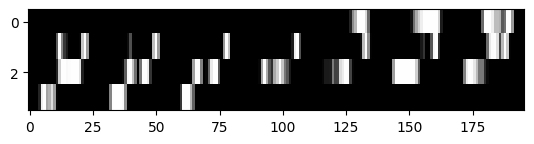

In [57]:
# reshape in 3 rows
plt.imshow(x_train_sub[563].reshape(4,-1), cmap='gray', aspect=10, interpolation='none')

In [58]:
# create ESN

esn = EchoStateNetwork(input_size=1, hidden_size=100, rho_h=0.8, omega_x= 1, head=None)

<class 'scipy.sparse._coo.coo_matrix'>


In [59]:
type(esn.W_x)

scipy.sparse._coo.coo_matrix

In [60]:
# get the hidden states
print(x_train_sub.shape)

hidden_states =[]
for i in tqdm(range(1000)):
    h = esn.create_reservoir(x_train_sub[i], alpha_leak=0.9)
    hidden_states.append(h)
hidden_states = np.array(hidden_states)
print(hidden_states.shape)

(1000, 784)


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


(1000, 784, 100)


In [61]:
last_hidden_states = hidden_states[:,-1,:]
hidden_states = hidden_states.reshape(hidden_states.shape[0], -1)

In [62]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, penalty='l2', C=1e-2)
logreg.fit(hidden_states.reshape(1000,-1), y_train_sub)

LogisticRegression(C=0.01, max_iter=1000)

In [63]:
logreg.predict(hidden_states)

array([7, 7, 7, 1, 7, 7, 1, 7, 1, 7, 1, 1, 1, 7, 1, 7, 7, 1, 1, 7, 7, 7,
       7, 1, 1, 1, 7, 7, 7, 1, 7, 1, 7, 7, 7, 1, 1, 7, 7, 7, 1, 1, 7, 7,
       1, 7, 1, 1, 7, 1, 1, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 1, 1, 7, 7, 1,
       1, 1, 1, 7, 1, 7, 1, 1, 7, 7, 1, 1, 1, 7, 7, 7, 7, 7, 7, 1, 7, 7,
       7, 7, 7, 7, 7, 1, 1, 7, 7, 1, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 7, 7,
       7, 7, 1, 1, 7, 7, 7, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 1, 1, 7,
       1, 7, 7, 1, 1, 1, 1, 7, 7, 1, 7, 7, 1, 1, 1, 7, 7, 1, 1, 7, 1, 7,
       7, 7, 7, 1, 7, 7, 7, 1, 7, 1, 7, 1, 7, 7, 1, 7, 7, 7, 7, 1, 1, 1,
       7, 1, 7, 7, 1, 7, 7, 7, 1, 7, 1, 1, 7, 7, 1, 1, 7, 7, 7, 7, 7, 1,
       1, 7, 1, 1, 1, 7, 7, 1, 7, 7, 1, 7, 7, 1, 7, 1, 7, 1, 7, 7, 1, 7,
       1, 7, 7, 7, 7, 1, 7, 7, 1, 7, 7, 1, 7, 1, 7, 1, 7, 7, 7, 7, 1, 7,
       1, 7, 7, 1, 7, 7, 1, 7, 7, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 1, 7,
       7, 7, 1, 7, 7, 1, 1, 7, 7, 7, 1, 7, 1, 7, 1, 7, 7, 1, 7, 0, 7, 7,
       1, 1, 7, 7, 1, 1, 7, 0, 7, 1, 7, 7, 1, 7, 1,

In [64]:
# compute the accuracy
from sklearn.metrics import accuracy_score
y_train_pred = logreg.predict(hidden_states)
accuracy_score(y_train_sub, y_train_pred)


0.231

In [15]:
# validation
val_hidden_states = []
for x_i in tqdm(x_valid_sub):
    h = esn.create_reservoir(x_i)
    val_hidden_states.append(h)

val_hidden_states = np.array(val_hidden_states)
#val_hidden_states = val_hidden_states[:,-1,:]


  6%|▌         | 59/1000 [00:08<02:22,  6.58it/s]


KeyboardInterrupt: 

In [65]:

y_valid_pred = logreg.predict(val_hidden_states.reshape(val_hidden_states.shape[0], -1))
accuracy_score(y_valid_sub, y_valid_pred)


NameError: name 'x_valid_hidden' is not defined

In [132]:
class TorchESN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rho, omega) -> None:
        super(TorchESN, self).__init__()
        self.esn = nn.RNN(input_size=input_size, hidden_size=100, nonlinearity='tanh')
        # make rnn not learnable
        for param in self.esn.parameters():
            param.requires_grad = False
        
        self.fc = nn.Linear(hidden_size, output_size)

    def init_weights(self, rho, omega):
        # init weights at echo state property

        # input to hidden
        self.esn.weight_ih_l0.data = torch.randn_like(self.esn.weight_ih_l0.data) * omega / torch.norm(self.esn.weight_ih_l0.data, p=2)

        # hidden to hidden
        spectral_radius = torch.max(torch.abs(torch.eig(self.esn.weight_hh_l0.data)[0])).real
        self.esn.weight_hh_l0.data = torch.randn_like(self.esn.weight_hh_l0.data) * rho / spectral_radius

    


In [34]:
esn = TorchESN(input_size=1, hidden_size=100, output_size=10, rho=1.1, omega=0.9)

TypeError: RNNBase.__init__() got an unexpected keyword argument 'requires_grad'